This notebook is the sequel of a [previous iteration]() where I explored the stranding dataset, and developed some models where the stranding is conditional on seasonality. Here, section 1.- is a recap of one of these models, where the stranding count is inferred from the month of the observations. Section 2.- is the introduction of zero-inflated poisson (ZIP) as means to deal with the excess of '0s' present in the dataset, again using month as predictor. Section 3.- is an extension of section 2.-, but where I bring in all data that may potentially be used as predictors

In [1]:
import pathlib
import pickle
import sys
import warnings
from seaborn import heatmap, stripplot
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as pl
from matplotlib import rcParams
from theano import tensor as tt
from cmocean.cm import thermal

### 1 - The basic Poisson Model for fitting Count Data

This section is a recap of a preceding notebook, where I fit a bayesian generalized model with a Poisson likelihood to infer stranding counts, and where I used the month of the stranding as a predictor.

In [2]:
# graphical setup
% matplotlib inline
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['font.size'] = 16

In [3]:
print('Version Info', end='\n\n')

print(f'System: {sys.version}')
print('-' * 75)
print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'PyMC3: {pm.__version__}')

Version Info

System: 3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]
---------------------------------------------------------------------------
pandas: 0.23.2
numpy: 1.14.5
PyMC3: 3.5


In [4]:
# additional settings
warnings.filterwarnings('ignore')

In [28]:
home = pathlib.Path.home().as_posix()
data_subpath = '/DATA/Beaching_Project/PklJar/'

df_features = pd.read_pickle(f'{home}{data_subpath}DFFEATURES.pkl')
df_targets = pd.read_pickle(f'{home}{data_subpath}DFLABELS.pkl')

df_features.head(3).T

,1999-01-01 00:00:00,1999-01-02 00:00:00,1999-01-03 00:00:00
Ddelph_count,0.000000,0.000000,0.000000
Lageno_count,0.000000,0.000000,0.000000
FRDH,20999.987708,20995.609097,21050.438681
FRDV,49201.519653,49202.668125,52278.752361
OTTH,17459.028474,17455.841440,17458.259553
OTTV,53549.040000,53548.428889,53551.839861
Kp_index,15.750000,17.750000,10.500000
Sunspot_No,89.000000,94.000000,80.000000
Dst_index,-3.333333,-7.458333,-4.125000
AE_index,94.333333,139.875000,59.958333


In [29]:
df_targets.head(3).T

,1999-01-01 00:00:00,1999-01-02 00:00:00,1999-01-03 00:00:00
NUM_ANIMALS,0.0,0.0,0.0
SPECIES_Delphinus delphis,0.0,0.0,0.0
SPECIES_Globicephala melas,0.0,0.0,0.0
SPECIES_Grampus griseus,0.0,0.0,0.0
SPECIES_Lagenorhynchus acutus,0.0,0.0,0.0
SPECIES_Stenella coeruleoalba,0.0,0.0,0.0
SPECIES_Tursiops truncatus,0.0,0.0,0.0
CONDITION_CODE_1,0.0,0.0,0.0
CONDITION_CODE_2,0.0,0.0,0.0
CONDITION_CODE_3,0.0,0.0,0.0


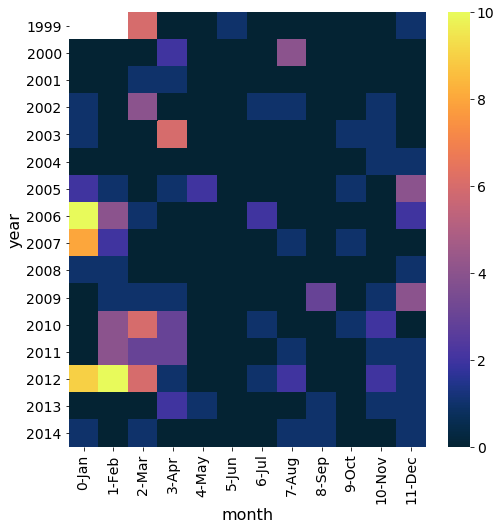

In [9]:
# and graphically
_, ax = pl.subplots(figsize=(8,8))
heatmap(monYearPivot, ax=ax, cmap=thermal);
ax.set_xlabel('month');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [alpha_month, sigma_month_log__]
100%|██████████| 7000/7000 [00:14<00:00, 477.53it/s]


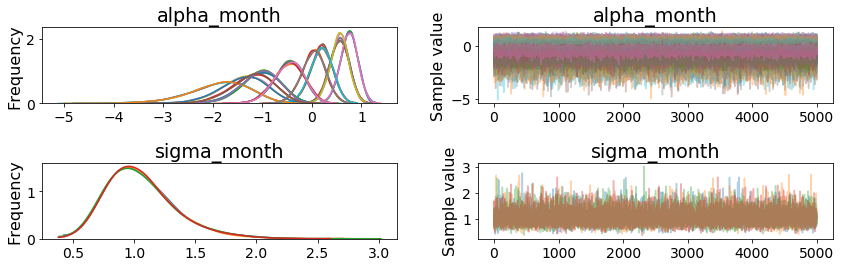

In [10]:
n_months = df_T_M.month.unique().size
with pm.Model() as mpp_1:
    # priors
   # alpha = pm.Normal('alpha', 0, 1)
    sigma_month = pm.HalfCauchy('sigma_month', 1)
    alpha_month = pm.Normal('alpha_month', 0, sigma_month, shape=n_months)
    # link
    lambda_ = pm.math.exp(alpha_month[df_T_M.month.values])
    # likelihood
    events = pm.Poisson('events', lambda_, observed=df_T_M.event)
    # sampling
    trace_mpp1 = pm.sample(5000, tune=2000, chains=4)
pm.traceplot(trace_mpp1);

Examining the impact each month has on the number of events we see that in terms of effects on the number of beachings:

* the common mean, alpha is now centered around -0.5, which gives a background beaching rate of 0.6/month
* the first 3 months (Jan, Feb, Mar) have a significantly positive impact
* Apr and Dec have also positive impact that, however is not significantly different than 0
* May-July and Sept-Oct have a negative impact, but ony June is significantly different than 0.

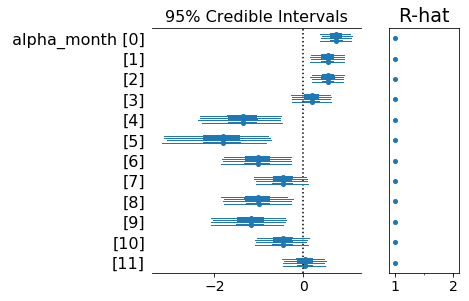

In [11]:
pm.forestplot(trace_mpp1, varnames=['alpha_month']);

In [12]:
# GET MODEL POSTERIOR BY MONTH
alpha_month_post = trace_mpp1.get_values('alpha_month', combine=True)
lambda_mpp1_post = np.exp(alpha_month_post)
expected_alpha_mpp1 = np.mean(lambda_mpp1_post, axis=0)
hpd_95_lambda_mpp1_post = pm.hpd(lambda_mpp1_post)
df_mpp1 = pd.DataFrame(np.c_[expected_alpha_mpp1, hpd_95_lambda_mpp1_post], columns=['exp_mdl', 'hpd95_lo', 'hpd95_hi'])

# GET MODEL POSTERIOR
lambda_mpp1_post_ = np.exp(alpha_month_post[:,df_T_M.month])
expected_lambda_mpp1_ = np.mean(lambda_mpp1_post_, axis=0)
hpd_95_lambda_mpp1_post_ = pm.hpd(lambda_mpp1_post_)

# GET POSTERIOR PREDICTIVE CHECK
ppc_mpp1 = pm.sample_ppc(trace_mpp1, model=mpp_1, progressbar=False)['events'] # get ppc for mp_0
# compute 95% credibility intervals of ppc
hpd_95_ppc_mpp1 = pm.hpd(ppc_mpp1)
expected_ppc_mpp1 = np.mean(ppc_mpp1, axis=0)

In [13]:
df_mpp1['expected_ppc'] = expected_ppc_mpp1[10:22]
df_mpp1['hpd95_ppc_lo'] = hpd_95_ppc_mpp1[10:22, 0]
df_mpp1['hpd95_ppc_hi'] = hpd_95_ppc_mpp1[10:22, 1]

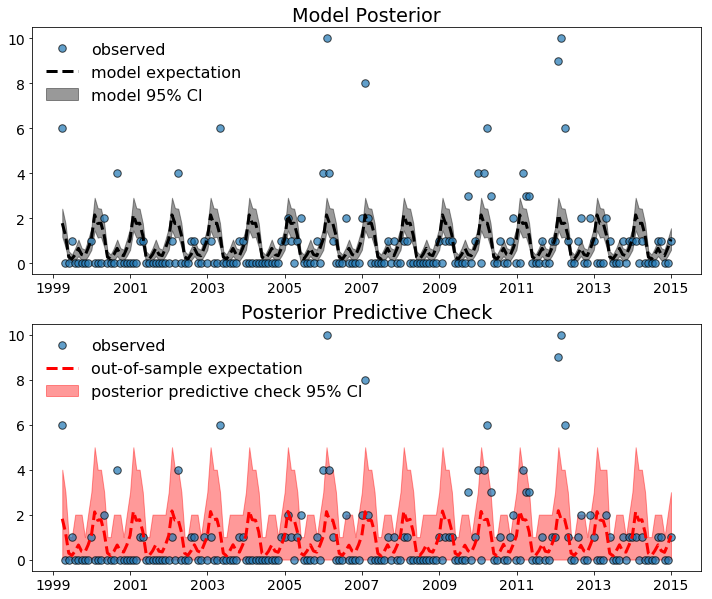

In [17]:
dates = np.array(df_T_M.index.to_pydatetime())
_, ax = pl.subplots(nrows=2, figsize=(12, 10))
ax[0].plot(dates, df_T_M.event, marker='.', markersize=15,
        markeredgecolor='k', ls='', label='observed', alpha=0.7)
ax[0].plot(dates, expected_lambda_mpp1_.T, color='k', ls='--', lw=3,
        label='model expectation')
ax[0].fill_between(dates, y1=hpd_95_lambda_mpp1_post_[:,0],
                y2=hpd_95_lambda_mpp1_post_[:, 1], color='k', alpha=0.4,
               label='model 95% CI');
ax[0].set_title('Model Posterior')
ax[0].legend(framealpha=0)                   
ax[1].plot(dates, df_T_M.event, marker='.', markersize=15,
        markeredgecolor='k', ls='', label='observed', alpha=0.7)
ax[1].plot(dates, expected_ppc_mpp1, ls='--', color='r', lw=3, 
        label='out-of-sample expectation')
ax[1].fill_between(dates, y1=hpd_95_ppc_mpp1[:, 0], y2=hpd_95_ppc_mpp1[:, 1], color='red',
               alpha=0.4, label='posterior predictive check 95% CI')
ax[1].set_title('Posterior Predictive Check')
ax[1].legend(framealpha=0);

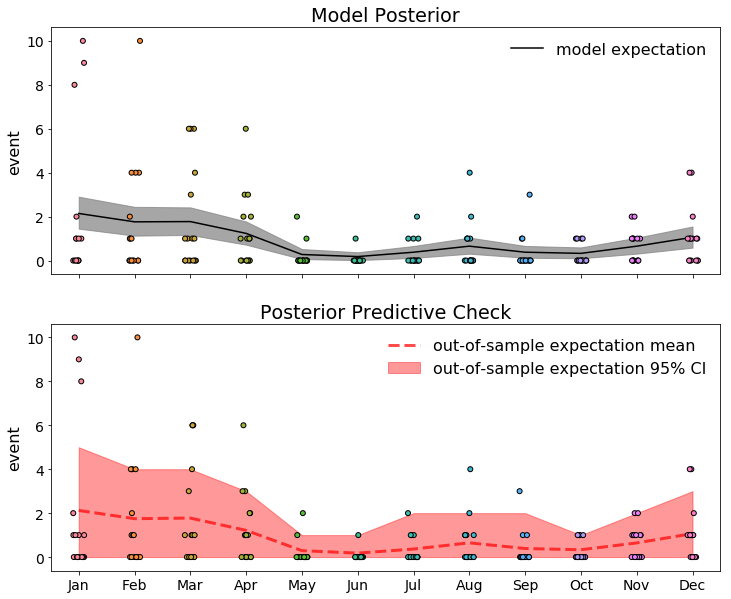

In [22]:
_, ax = pl.subplots(nrows=2, figsize=(12,10), sharex=True)
stripplot(x='month_name', y='event', data=df_T_M.sort_values('month'), ax=ax[0], jitter=True,
         edgecolor='k', linewidth=1)
ax[0].plot(df_mpp1.exp_mdl, color='k', label='model expectation')
ax[0].fill_between(df_mpp1.index, y1=df_mpp1.hpd95_lo, y2=df_mpp1.hpd95_hi, alpha=0.7, color='gray');
ax[0].set_title('Model Posterior')
ax[0].set_xlabel('')
ax[0].legend(framealpha=0)
stripplot(x='month_name', y='event', data=df_T_M.sort_values('month'), ax=ax[1], jitter=True,
         edgecolor='k', linewidth=1)
ax[1].plot(df_mpp1.expected_ppc, ls='--', lw=3, color='r', label='out-of-sample expectation mean', alpha=0.7)
ax[1].fill_between(df_mpp1.index, y1=df_mpp1.hpd95_ppc_lo, y2=df_mpp1.hpd95_ppc_hi, color='red',
               alpha=0.4, label='out-of-sample expectation 95% CI')
ax[1].set_xlabel('')
ax[1].set_title('Posterior Predictive Check')
ax[1].legend(framealpha=0);

Now, we can add predictors to our model and see how well we improve. One remaining problem is that the zero-event may be inflated. This may arise because often there is more than one reason for not observing an event, even if the necessary or threshold conditions have been satisfied. In the case of count data such as these, this can be addressed by using a zero-inflated poisson process, where the 0-event is parameterized separately from the non-zero event. This is an example of a mixture model the exploration of which, in the context of this data, will be the subject of subsequent notebooks along with the use of additional features (predictor variables).

### The Zero-Inflated Poisson (ZIP) Model